# DeepArk Figure 1 Notebook
- This notebook recreates Figure 1 from the DeepArk manuscript.

# Setup
- Import packages needed and configure some options.

In [9]:
# Stats etc.
import numpy
import pandas

# Viz
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook

# Configure pandas printing.
pandas.options.display.max_rows = 12

# Test Performance for Trained Models
- The following code produces the classification accuracy figures shown in the DeepArk manuscript. In specific, it produces Figure 1B-D. 
- This notebook is configured to run without having to re-train new models. Thus, it currently uses the outputs from the DeepArk models trained for the manuscript.
- If you would like to reproduce these figures for a new model you have trained (i.e. not using the the existing performance outputs), you will need to change the paths for those files.

## Configure Plot Appearance

In [10]:
def f1_plot_config():
    seaborn.set()
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
    d = {"lines.linewidth": 0.4,
        "axes.linewidth": 0.4,
        "ytick.major.width": 0.4,
        "ytick.minor.width": 0.4,
        "xtick.major.width": 0.,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "ytick.minor.size": 1.6,
        "xtick.minor.size": 1.6}

    for k, v in d.items():
        matplotlib.rcParams[k] = v
        
    matplotlib.rcParams['xtick.major.pad'] = 1
    matplotlib.rcParams['ytick.major.pad'] = 1
    matplotlib.rcParams["figure.dpi"] = 300
    matplotlib.rcParams["axes.facecolor"] = "w"
    matplotlib.rcParams["figure.facecolor"] = "w"
    matplotlib.rcParams["xtick.labelsize"] = 6
    matplotlib.rcParams["ytick.labelsize"] = 6
    matplotlib.rcParams["axes.labelsize"] = 6
    matplotlib.rcParams['axes.titlesize'] = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['axes.titlepad'] = 4
    matplotlib.rcParams['axes.ymargin'] = 0
    matplotlib.rcParams['axes.xmargin'] = 0
    for x in ["left", "right", "top", "bottom"]:
        matplotlib.rcParams["figure.subplot.{}".format(x)] = 0.08 if x in {"left",  "bottom"} else 0.99

    matplotlib.rcParams["legend.fancybox"] = False

    # Legend settings:    
    d = {"legend.borderpad" : 0.4,  
        "legend.labelspacing" : 0.0,  
        "legend.handlelength" : 2.0,  
        "legend.handleheight" : 0.7,
        "legend.handletextpad" : 0.,
        "legend.borderaxespad" : 0.5,
        "legend.fontsize": 6,
        "legend.borderpad": 0.4}

    #legend.columnspacing}
    for k, v in d.items():
        matplotlib.rcParams[k] = v

## Load Test Performance
- To modify this to load test performance from reproduction, change line 5 to load the test performance file output from running `evaluate.sh`

In [11]:
test_dict = dict()
for organism, sci_name in zip(["dm3.05.v2", "ce10.05.v2", "mm9.05.v2", "danRer11.05.v2"], 
                              ["drosophila_melanogaster", "caenorhabditis_elegans", "mus_musculus", "danio_rerio"]):
    # Read in data frame with performance.
    df = pandas.read_csv("../DeepArk/data/{}.tsv".format(sci_name), sep="\t") # NOTE: Change this to read in your test performance file!
    df = df[["class" if "class" in df.columns else "accession", 
             "roc_auc" if "roc_auc" in df.columns else "test_auc_roc",
             "average_precision" if "average_precision" in df.columns else "test_auc_prc"]]
    df.columns = ["accession", "roc_auc", "average_precision"]
    
    # Read in metadata.
    meta_df = pandas.read_csv("../DeepArk/data/{}.tsv".format(sci_name), sep="\t") # NOTE: DO NOT change this.
    meta_df.drop(["test_auc_roc", "test_auc_prc"], axis=1, inplace=True)
    df = df.merge(meta_df, on="accession", validate="one_to_one")
    
    # Ensure proper ordering.
    with open("../train/distinct_features.{}.txt".format(sci_name), "r") as read_file:
        cur_accessions = [x.strip() for x in read_file.readlines()]
    df.set_index("accession", inplace=True)
    df = df.loc[cur_accessions, :]
    test_dict[organism] = df
    print("Finished {}".format(sci_name))
print("Finished.")

Finished drosophila_melanogaster
Finished caenorhabditis_elegans
Finished mus_musculus
Finished danio_rerio
Finished.


## Produce Figure 1B

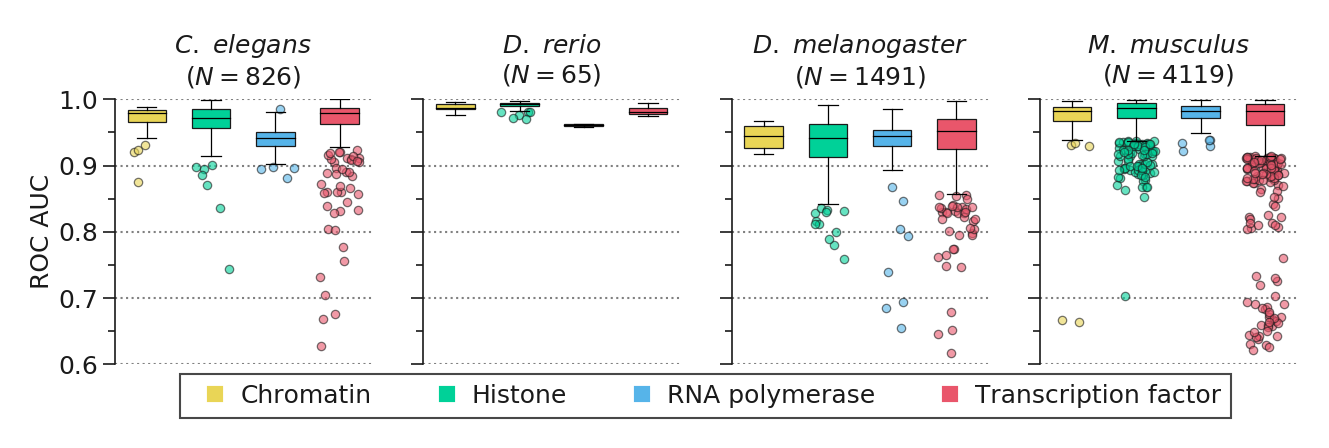

In [12]:
labels = [
 'Chromatin',
 'Histone',
 'RNA polymerase',
 'Transcription factor']


palette = ["#e9d556", "#00d198","#56b4e9","#e9566b"]
metric = "roc_auc" 
ylabel = "ROC AUC"


# Iterate over each species, calculating outliers etc.
merged_df = list()
merged_ol_df = list()
titles = list()
for organism, sci_name in zip(["ce10.05.v2", "danRer11.05.v2", "dm3.05.v2",  "mm9.05.v2"], 
                          ["caenorhabditis_elegans", "danio_rerio", "drosophila_melanogaster", "mus_musculus"]):
    # Format names.
    df = test_dict[organism].copy()
    df = df.sort_values("assay_target_class")
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x != "TFs and others" else "Transcription factor" )
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x not in {"DNase-seq", "ATAC-seq"} else "Chromatin")
    df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    titles.append("$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$")

    # Calculate outliers
    tmp = df.copy()[["assay_target_class", metric]].dropna()
    tmp = tmp.sort_values("assay_target_class").groupby("assay_target_class")[metric].agg(lambda x: matplotlib.cbook.boxplot_stats(x))
    ol_df = list()
    for (label, stats) in tmp.reset_index().itertuples(name=None, index=False):
        for s in stats:
            for x in s["fliers"]:
                ol_df.append((label, x))
    ol_df = pandas.DataFrame(ol_df, columns=["assay_target_class", metric])
    ol_df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    merged_ol_df.append(ol_df)
    merged_df.append(df)

# Concatenate outputs.
merged_ol_df = pandas.concat(merged_ol_df, axis=0)
merged_df = pandas.concat(merged_df, axis=0)
merged_df = merged_df[~numpy.isnan(merged_df[metric].values)]
hue_order = sorted(merged_df.assay_target_class.unique())

# Configure plot.
f1_plot_config()
numpy.random.seed(1337) # This is for the scattering to be reproducible
fig, (axes) = plt.subplots(1, 4, figsize=(11/2.54, 11/2.54/(1.61803398875*2)), dpi=300, facecolor='w', edgecolor='k')
lc = "black"
lw = 0.3
col_width = 0.6

# Plot outliers.
for i, (species, ax) in enumerate(zip(titles, axes[:4])):
    for y in [0.6, 0.7, 0.8, 0.9, 1]:
        ax.axhline(xmin=0, xmax=3, y=y, linestyle=':', color="grey", linewidth=0.5, zorder=-1)
    xpositions = numpy.arange(4) + 0.5 # Centering.
        
    # Plot outliers for each assay target class.
    tmp = merged_ol_df[merged_ol_df.species == species].sort_values("assay_target_class").copy()
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        x = numpy.array([xpositions[x_i]]*d.shape[0]) + ((numpy.random.uniform(size=d.shape[0]) - 0.5) * col_width)
        if len(x) != 0 and max(x) > 4:
            s = "Found x out of bounds: {}".format(x)
            raise ValueError(s)
#         x +
        ax.scatter(x=x,
                    y=d[metric].values,
                    label=assay_target_class,
                    color=palette[x_i],
                    edgecolor='k',
                    alpha=0.6,
                    linewidth=0.3,
                    s=4,
                    zorder=0)
    
    # Prepare data for boxplots.
    tmp = merged_df[merged_df.species == species].sort_values("assay_target_class").copy()
    bplot_data = []
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        bplot_data.append(d[metric].values)
    if numpy.isnan(bplot_data[-1]).any():
        print("Found NaNs in plotted data w/ shape {}".format(d[numpy.isnan(bplot_data[-1])].shape))
        display(d[numpy.isnan(bplot_data[-1])])
        
    # Plot boxplots.
    bplot = ax.boxplot(bplot_data,
                       vert=True,
                       patch_artist=True,
                       labels=hue_order,
                       showfliers=False,
                       widths=[col_width]*4,
                       positions=xpositions,
                       medianprops={"linewidth": lw,
                                    "color": lc},
                       boxprops={"zorder": 0.9,
                                 "edgecolor": lc,
                                 "linewidth": lw},
                       whiskerprops={"color": lc,
                                     "linewidth": lw,
                                     "linestyle": "-"},
                       capprops={"color": lc,
                                 "linewidth": lw})
    for patch, color in zip(bplot['boxes'], palette):
        patch.set_facecolor(color)
    
    # Format the axes.
    ax.set_xlim(0., 4.)
    for x in ["top", "bottom", "right"]:
        ax.spines[x].set_visible(False)
    ax.set_ylim(0.6, 1.)
    ax.set_yticks([0.65, 0.75, 0.85, 0.95], minor=True)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1], minor=False) 
    if i == 0:
        ax.set_ylabel(ylabel, labelpad=1)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_title(species + "\n($N={}$)".format(tmp.shape[0]))
    
# Shift things a bit.
plt.subplots_adjust(bottom=0.17, top=0.83)
    
# Create legend 
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
handles = list()
for c, l in zip(palette,  hue_order):
                #['Chromatin','Histone', 'RNA polymerase', 'Transcription factor']):
    x, = ax0.plot([], marker="s", markersize=3, linestyle="", color=c,  label=l)
    handles.append(x)
legend = ax0.legend(handles=handles, loc="lower center", ncol=4, frameon=True)#bbox_to_anchor=(1, -0.05), ncol=4, frameon=True)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("k")

# Shift legend down.
bbox = legend.get_bbox_to_anchor().inverse_transformed(ax0.transAxes)
bbox.y1 = -0.25
bbox.y0 = -0.25
legend.set_bbox_to_anchor(bbox, transform = ax0.transAxes)

plt.show()
plt.close(fig)

## Produce Figure 1C

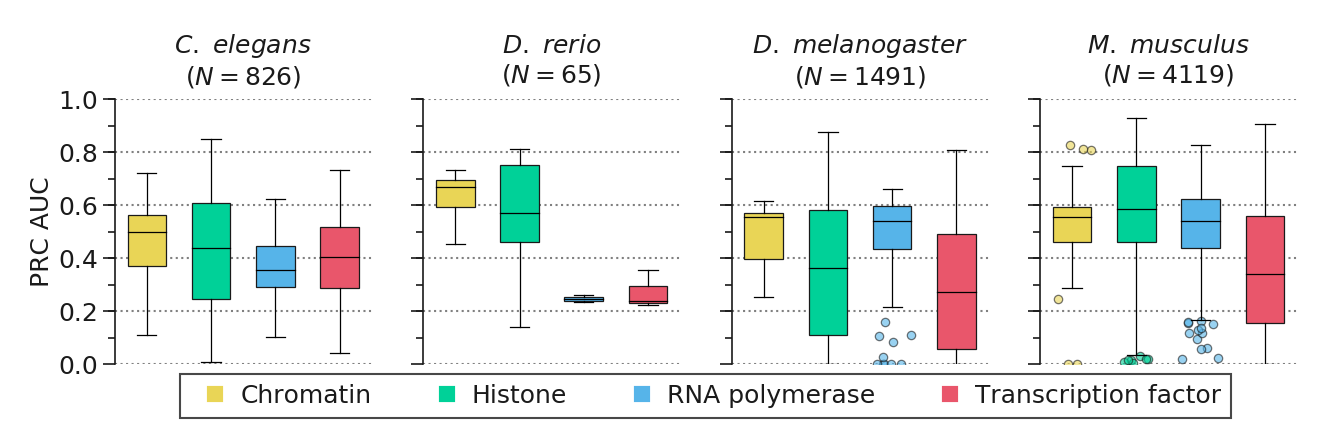

In [13]:
# Constants.
yticks = [0., 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Chromatin',
 'Histone',
 'RNA polymerase',
 'Transcription factor']
palette = ["#e9d556", "#00d198","#56b4e9","#e9566b"]
metric = "average_precision" 
ylabel = "PRC AUC"

# Create DF of outliers and points etc.
merged_df = list()
merged_ol_df = list()
titles = list()
for organism, sci_name in zip(["ce10.05.v2", "danRer11.05.v2", "dm3.05.v2",  "mm9.05.v2"], 
                          ["caenorhabditis_elegans", "danio_rerio", "drosophila_melanogaster", "mus_musculus"]):
    
    df = test_dict[organism].copy()
    df = df.sort_values("assay_target_class")
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x != "TFs and others" else "Transcription factor" )
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x.upper() not in {"DNase-seq", "ATAC-seq"} else "Chromatin")
    df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    titles.append("$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$")

    # Calculate outliers
    tmp = df.copy()[["assay_target_class", metric]].dropna()
    tmp = tmp.sort_values("assay_target_class").groupby("assay_target_class")[metric].agg(lambda x: matplotlib.cbook.boxplot_stats(x))
    ol_df = list()
    for (label, stats) in tmp.reset_index().itertuples(name=None, index=False):
        for s in stats:
            for x in s["fliers"]:
                ol_df.append((label, x))
    ol_df = pandas.DataFrame(ol_df, columns=["assay_target_class", metric])
    ol_df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    merged_ol_df.append(ol_df)
    merged_df.append(df)

# Concat plot params.
merged_ol_df = pandas.concat(merged_ol_df, axis=0)
merged_df = pandas.concat(merged_df, axis=0)
merged_df = merged_df[~numpy.isnan(merged_df[metric].values)]

# Configure plot.
f1_plot_config()
numpy.random.seed(1337)
hue_order = sorted(merged_df.assay_target_class.unique())
fig, (axes) = plt.subplots(1, 4, figsize=(11/2.54, 11/2.54/(1.61803398875*2)), dpi=300, facecolor='w', edgecolor='k')
lc = "black"
lw = 0.3
col_width = 0.6

# Plot outliers.
for i, (species, ax) in enumerate(zip(titles, axes[:4])):
    for y in yticks:
        ax.axhline(xmin=0, xmax=3, y=y, linestyle=':', color="grey", linewidth=0.5, zorder=-1)
        
    xpositions = numpy.arange(4) + 0.5
        
    # Plot outliers for each assay target class.
    tmp = merged_ol_df[merged_ol_df.species == species].sort_values("assay_target_class").copy()
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        x = numpy.array([xpositions[x_i]]*d.shape[0]) + ((numpy.random.uniform(size=d.shape[0]) - 0.5) * col_width)
        if len(x) != 0 and max(x) > 4:
            s = "Found x out of bounds: {}".format(x)
            raise ValueError(s)
        ax.scatter(x=x,
                    y=d[metric].values,
                    label=assay_target_class,
                    color=palette[x_i],
                    edgecolor='k',
                    alpha=0.6,
                    linewidth=0.3,
                    s=4,
                    zorder=0)
    
    # Prepare data for boxplots.
    tmp = merged_df[merged_df.species == species].sort_values("assay_target_class").copy()
    bplot_data = []
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        bplot_data.append(d[metric].values)
    if numpy.isnan(bplot_data[-1]).any():
        print(d[numpy.isnan(bplot_data[-1])].shape)
        display(d[numpy.isnan(bplot_data[-1])])
        
    # Plot boxplots.
    # See: https://github.com/mwaskom/seaborn/blob/4ee5c51900dbd337a9bc9bceac3bdd9de3095dcb/seaborn/categorical.py#L478
    bplot = ax.boxplot(bplot_data,
                       vert=True,
                       patch_artist=True,
                       labels=hue_order,
                       showfliers=False,
                       widths=[col_width]*4,
                       positions=xpositions,
                       medianprops={"linewidth": lw,
                                    "color": lc},
                       boxprops={"zorder": 0.9,
                                 "edgecolor": lc,
                                 "linewidth": lw},
                       whiskerprops={"color": lc,
                                     "linewidth": lw,
                                     "linestyle": "-"},
                       capprops={"color": lc,
                                 "linewidth": lw})
    for patch, color in zip(bplot['boxes'], palette):
        patch.set_facecolor(color)
    
    # Format the axes.
    ax.set_xlim(0., 4.)
    for x in ["top", "bottom", "right"]:
        ax.spines[x].set_visible(False)
    
    ax.set_ylim(0., 1.)
    ax.set_yticks(numpy.arange(0, 1, 0.1) + 0.1, minor=True)
    ax.set_yticks(yticks, minor=False) 
    if i == 0:
        ax.set_ylabel(ylabel, labelpad=1)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_title(species + "\n($N={}$)".format(tmp.shape[0]))
        
# Adjust plot.
plt.subplots_adjust(bottom=0.17, top=0.83)#bottom=0.1, right=0.8, top=0.9)

# Add legend.
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
handles = list()
for c, l in zip(palette, labels):
    x, = ax0.plot([], marker="s", markersize=3, linestyle="", color=c,  label=l)
    handles.append(x)
legend = ax0.legend(handles=handles, loc="lower center", ncol=4, frameon=True)#bbox_to_anchor=(1, -0.05), ncol=4, frameon=True)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("k")
bbox = legend.get_bbox_to_anchor().inverse_transformed(ax0.transAxes)
bbox.y1 = -0.25
bbox.y0 = -0.25
legend.set_bbox_to_anchor(bbox, transform = ax0.transAxes)

plt.show()
plt.close(fig)

## Produce Figure 1D

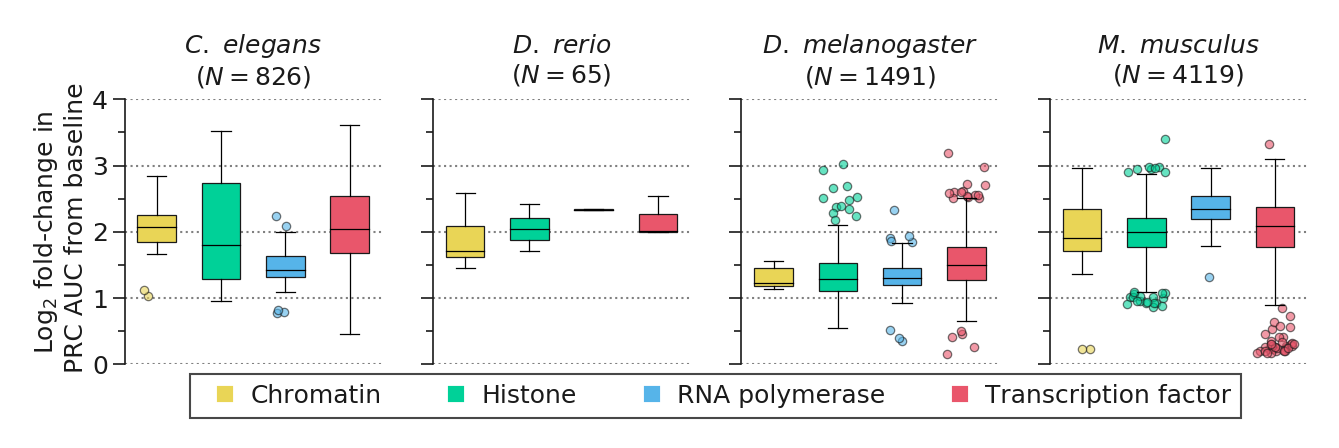

In [14]:
# Various constants.
yticks = [0, 1, 2, 3, 4]
labels = ['Chromatin',
 'Histone',
 'RNA polymerase',
 'Transcription factor']
metric = "lfc_average_precision" 
ylabel = "Log$_2$ fold-change in\n PRC AUC from baseline"

# Iterate over species and calculate outliers etc.
merged_df = list()
merged_ol_df = list()
titles = list()
for organism, sci_name in zip(["ce10.05.v2", "danRer11.05.v2", "dm3.05.v2",  "mm9.05.v2"], 
                          ["caenorhabditis_elegans", "danio_rerio", "drosophila_melanogaster", "mus_musculus"]):
    df = test_dict[organism].copy()
    df = df.sort_values("assay_target_class")
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x != "TFs and others" else "Transcription factor" )
    df["assay_target_class"] = df.assay_target_class.apply(lambda x: x if x not in {"DNase-seq", "ATAC-seq"} else "Chromatin")
    df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    titles.append("$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$")
    
    # Calculate the fold-change AUC PRC metric.
    df["baseline_average_precision"] = df["n_positive_test_examples"].values / 1000000 # NOTE: Use a different number here if you do not use 1M test examples.
    df["fc_average_precision"] = df["average_precision"].values / df["baseline_average_precision"].values
    df["lfc_average_precision"] = numpy.log10(df["average_precision"].values / df["baseline_average_precision"].values)
    
    # Calculate outliers
    tmp = df.copy()[["assay_target_class", metric]].dropna()
    tmp = tmp.sort_values("assay_target_class").groupby("assay_target_class")[metric].agg(lambda x: matplotlib.cbook.boxplot_stats(x))
    ol_df = list()
    for (label, stats) in tmp.reset_index().itertuples(name=None, index=False):
        for s in stats:
            for x in s["fliers"]:
                ol_df.append((label, x))
    ol_df = pandas.DataFrame(ol_df, columns=["assay_target_class", metric])
    ol_df["species"] = "$" + sci_name[0].upper() + "." + "\ " + sci_name.split("_")[1] + "$"
    merged_ol_df.append(ol_df)
    merged_df.append(df)

# Calculate plot params.
merged_ol_df = pandas.concat(merged_ol_df, axis=0)
merged_df = pandas.concat(merged_df, axis=0)
merged_df = merged_df[~numpy.isnan(merged_df[metric].values)]
hue_order = sorted(merged_df.assay_target_class.unique())

# Configure the plot.
f1_plot_config()
numpy.random.seed(1337)
hue_order = sorted(merged_df.assay_target_class.unique())
fig, (axes) = plt.subplots(1, 4, figsize=(11/2.54, 11/2.54/(1.61803398875*2)), dpi=300, facecolor='w', edgecolor='k')
lc = "black"
lw = 0.3
col_width = 0.6

# Plot outliers.
for i, (species, ax) in enumerate(zip(titles, axes[:4])):
    for y in yticks:
        ax.axhline(xmin=0, xmax=3, y=y, linestyle=':', color="grey", linewidth=0.5, zorder=-1)        
    xpositions = numpy.arange(4) + 0.5
    # Plot outliers for each assay target class.
    tmp = merged_ol_df[merged_ol_df.species == species].sort_values("assay_target_class").copy()
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        x = numpy.array([xpositions[x_i]]*d.shape[0]) + ((numpy.random.uniform(size=d.shape[0]) - 0.5) * col_width)
        if len(x) != 0 and max(x) > 4:
            s = "Found x out of bounds: {}".format(x)
            raise ValueError(s)
        ax.scatter(x=x,
                    y=d[metric].values,
                    label=assay_target_class,
                    color=palette[x_i],
                    edgecolor='k',
                    alpha=0.6,
                    linewidth=0.3,
                    s=4,
                    zorder=0)
    
    # Prepare data for boxplots.
    tmp = merged_df[merged_df.species == species].sort_values("assay_target_class").copy()
    bplot_data = []
    for x_i, assay_target_class in enumerate(hue_order):
        d = tmp[tmp.assay_target_class == assay_target_class]
        bplot_data.append(d[metric].values)
    if numpy.isnan(bplot_data[-1]).any():
        print(d[numpy.isnan(bplot_data[-1])].shape)
        display(d[numpy.isnan(bplot_data[-1])])
        
    # Plot boxplots.
    # See: https://github.com/mwaskom/seaborn/blob/4ee5c51900dbd337a9bc9bceac3bdd9de3095dcb/seaborn/categorical.py#L478
    bplot = ax.boxplot(bplot_data,
                       vert=True,
                       patch_artist=True,
                       labels=hue_order,
                       showfliers=False,
                       widths=[col_width]*4,
                       positions=xpositions,
                       medianprops={"linewidth": lw,
                                    "color": lc},
                       boxprops={"zorder": 0.9,
                                 "edgecolor": lc,
                                 "linewidth": lw},
                       whiskerprops={"color": lc,
                                     "linewidth": lw,
                                     "linestyle": "-"},
                       capprops={"color": lc,
                                 "linewidth": lw})
    for patch, color in zip(bplot['boxes'], palette):
        patch.set_facecolor(color)
    
    # Format the axes.
    ax.set_xlim(0., 4.)
    for x in ["top", "bottom", "right"]:
        ax.spines[x].set_visible(False)
    
    ax.set_ylim(0., 4.)
#     ax.set_yticks(numpy.arange(0, 1, 0.05) + 0.1, minor=True)
    ax.set_yticks(numpy.arange(0, 4.) + 0.5, minor=True)
    ax.set_yticks(yticks, minor=False) 
#     print(ax.get_ylim())
    if i == 0:
        ax.set_ylabel(ylabel, labelpad=1)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_title(species + "\n($N={}$)".format(tmp.shape[0]))
        

# Adjust plot.
plt.subplots_adjust(bottom=0.17, top=0.83)#bottom=0.1, right=0.8, top=0.9)
    
# Create legend.
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
handles = list()
for c, l in zip(palette, labels):
    x, = ax0.plot([], marker="s", markersize=3, linestyle="", color=c,  label=l)
    handles.append(x)
legend = ax0.legend(handles=handles, loc="lower center", ncol=4, frameon=True)#bbox_to_anchor=(1, -0.05), ncol=4, frameon=True)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("k")

# Shift legend down.
bbox = legend.get_bbox_to_anchor().inverse_transformed(ax0.transAxes)
bbox.y1 = -0.25
bbox.y0 = -0.25
legend.set_bbox_to_anchor(bbox, transform = ax0.transAxes)

plt.show()
plt.close(fig)